In [1]:
'''
FUNCTIONS
Many functions for fit to basic lorentzians and also for the MB parameters:
    E - our x values, usually v [mm/s]
    I - intensity (usually of lowest peak pair)
    B_hf - hyperfine splitting magnetic field
    IS - isomer shift
    gamma - width of peak
    QS - quadrapole splitting (for some functions)
    b - baseline, number of counts without absorbtion

DATA
Yttrium orthoferrite
    Room temp run - fits decently but large errors bars as it was a short run and the center peaks are not the same size
    Temp scaling - this is all from when the oven wasn't working so is commented out

Magnetite - double magnetic sites
Hematite - nice magnetic fit with fitter with QS

Tourmaline - seems like a doublet, I think there should be QS and IS
'''

import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
import spinmob as s

In [8]:
'''
giving a fitter, returns an array of the fitted lorentzian1 parameters and errors in 2D array
arg: my_fitter = fit, x = integer value offset

'''
def getFits_lor(my_fitter, x):
    
    di = my_fitter.get_fit_results()
    results = [di[key] for key in di.keys()]
    
    center = [results[0+8*x], results[1+8*x]]
    dist = [results[2+8*x], results[3+8*x]]
    gamma = [results[4+8*x], results[5+8*x]]
    A = [results[6+8*x], results[7+8*x]]

    return [center, dist, gamma, A]

"""
Takes array of channels, and m, b of linear function
Returns array of velocities [mmsec]
"""
def chan_to_velo(channels, m, b):
    v = [m[0]*c + b[0] for c in channels]
    return v

def average(a, b, offset):
    
    center = (a[0] - b[0]) / 2.0 + offset[0]
    err = np.sqrt((np.sqrt((a[1])**2 + (b[1])**2)*0.5)**2+(offset[1])**2)
    
    return [center, err]

def lorentzian6const(E, center, dist, gamma, A, center_2, dist_2, gamma_2, A_2, center_3, dist_3, gamma_3, A_3, b):

    denom = (E-(center - dist))**2 + (gamma/2)**2
    denom_2 = (E-(center_2 - dist_2))**2 + (gamma_2/2)**2
    denom_3 = (E-(center_3 - dist_3))**2 + (gamma_3/2)**2
    denom_4 = (E-(center_3 + dist_3))**2 + (gamma_3/2)**2
    denom_5 = (E-(center_2 + dist_2))**2 + (gamma_2/2)**2
    denom_6 = (E-(center + dist))**2 + (gamma/2)**2
    
    return A*gamma**2/denom + A_2*gamma_2**2/denom_2 + A_3*gamma_3**2/denom_3 + A_3*gamma_3**2/denom_4 + A_2*gamma_2**2/denom_5 + A*gamma**2/denom_6 + b


def lorentzian6Magt(E, I, B_hf, IS, gamma, b):
    
    cal3 = 5.3115 #0.00055
    cal2 = 3.0639 #0.0006
    cal1 = 0.831 #0.0010

    denom = (E-( (-cal3/33.0)*B_hf + IS ) )**2 + (gamma/2)**2
    denom_2 = (E-( (-cal2/33.0)*B_hf + IS ) )**2 + (gamma/2)**2
    denom_3 = (E-( (-cal1/33.0)*B_hf + IS ) )**2 + (gamma/2)**2
    denom_4 = (E-( (cal1/33.0)*B_hf + IS ) )**2 + (gamma/2)**2
    denom_5 = (E-( (cal2/33.0)*B_hf + IS ))**2 + (gamma/2)**2
    denom_6 = (E-( (cal3/33.0)*B_hf + IS ) )**2 + (gamma/2)**2
    
    return 3*I*gamma**2/denom + 2*I*gamma**2/denom_2 + I*gamma**2/denom_3 + I*gamma**2/denom_4 + 2*I*gamma**2/denom_5 + 3*I*gamma**2/denom_6 + b

def lorentzian6MagtBL(E, I, B_hf, IS, gamma, b, c):
    
    cal3 = 5.3115 #0.00055
    cal2 = 3.0639 #0.0006
    cal1 = 0.831 #0.0010

    denom = (E-( (-cal3/33.0)*B_hf + IS ) )**2 + (gamma/2)**2
    denom_2 = (E-( (-cal2/33.0)*B_hf + IS ) )**2 + (gamma/2)**2
    denom_3 = (E-( (-cal1/33.0)*B_hf + IS ) )**2 + (gamma/2)**2
    denom_4 = (E-( (cal1/33.0)*B_hf + IS ) )**2 + (gamma/2)**2
    denom_5 = (E-( (cal2/33.0)*B_hf + IS ))**2 + (gamma/2)**2
    denom_6 = (E-( (cal3/33.0)*B_hf + IS ) )**2 + (gamma/2)**2
    
    return 3*I*gamma**2/denom + 2*I*gamma**2/denom_2 + I*gamma**2/denom_3 + I*gamma**2/denom_4 + 2*I*gamma**2/denom_5 + 3*I*gamma**2/denom_6 + b + c*E**2


def lorentzian6MagtQS(E, I, B_hf, IS, gamma, QS, b, c):
    
    cal3 = 5.3115 #0.00055
    cal2 = 3.0639 #0.0006
    cal1 = 0.831 #0.0010

    denom = (E-( (-cal3/33.0)*B_hf + IS +QS) )**2 + (gamma/2)**2
    denom_2 = (E-( (-cal2/33.0)*B_hf + IS -QS) )**2 + (gamma/2)**2
    denom_3 = (E-( (-cal1/33.0)*B_hf + IS -QS) )**2 + (gamma/2)**2
    denom_4 = (E-( (cal1/33.0)*B_hf + IS -QS) )**2 + (gamma/2)**2
    denom_5 = (E-( (cal2/33.0)*B_hf + IS -QS))**2 + (gamma/2)**2
    denom_6 = (E-( (cal3/33.0)*B_hf + IS +QS) )**2 + (gamma/2)**2
    
    return 3*I*gamma**2/denom + 2*I*gamma**2/denom_2 + I*gamma**2/denom_3 + I*gamma**2/denom_4 + 2*I*gamma**2/denom_5 + 3*I*gamma**2/denom_6 + b + c*E**2

#2 magnetic sites (so twice 6 peaks) with one baseline
def multiSiteLor6(E, I, B_hf, IS, gamma, QS, I_2, B_hf_2, IS_2, gamma_2, QS_2, b, c):
    
    Asites = lorentzian6MagtQS(E, I, B_hf, IS, gamma, QS, b, c)
    Bsites = lorentzian6MagtQS(E, I_2, B_hf_2, IS_2, gamma_2, QS_2, 0, 0)
    
    return Asites + Bsites

#one magnetic site and one electric site with one baseline
def multiSiteMag_Ele(E, I, B_hf, IS, gamma, QS, I_2, center, dist, gamma_2, b):
    
    Asites = lorentzian6MagtQS(E, I, B_hf, IS, gamma, QS, b)
    Bsites = lorentzian2Const(E, center, dist, gamma_2, I_2, 0)
    
    return Asites + Bsites

#2 lorentzians added together with one offset
def lorentzian2Const(E, center, dist, gamma, I, b):
    denom = (E- (center - dist) )**2 + (gamma/2)**2
    denom_2 = (E- (center + dist) )**2 + (gamma/2)**2

    return I*gamma**2/denom + I*gamma**2/denom_2 + b

#2 lorentzians added together with one offset
def lorentzian2QS(E, IS, QS, gamma, I, b):

    denom = (E- (IS - QS) )**2 + (gamma/2)**2
    denom_2 = (E- (IS + QS) )**2 + (gamma/2)**2

    return I*gamma**2/denom + I*gamma**2/denom_2 + b

#2 lorentzians added together with one offset
def lorentzian3Doublet(E, IS, QS, gamma, I, QS_2, I_2, IS_3, QS_3, I_3, b, c):

    Asite = lorentzian2QS(E, IS, QS, gamma, I, 0)
    Bsite = lorentzian2QS(E, IS, QS_2, gamma, I_2, 0)
    Csite = lorentzian2QS(E, IS_3, QS_3, gamma, I_3, 0)


    return Asite + Bsite + Csite + b + c*E**2

In [9]:
# channel to velocity relation from calibration data
b = [11.000776381475806, 0.0011164921537570854] 
m = [-0.08527733629051013, 8.194955387410484e-06]


## Temperture scaling
Yttrium orthoferrite  
Looking for Neel temperature

In [10]:
'''
data - data loaded from np.loadtxt
guess - string of guesses of parameters for lor fit
peak - number of peaks to fit (currently either 2 or 6)
'''
def fitYtt(data, guess, peaks):
    data = np.transpose(data)
    data[1][511] = (data[1][510] + data[1][0])/2
    ydataerr = np.sqrt(data[1])

    dataL = [data[0][0:256], data[1][0:256], ydataerr[0:256]]
    
    velocities = chan_to_velo(dataL[0], m, b)

    my_fitter = s.data.fitter()
    my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
                  , plot_guess=False, fpoints=None, xlabel = "Velocity [mm/s]" , ylabel = "Counts")

    if peaks == 6: 
    #6 fit
        my_fitter.set_functions(f=lorentzian6const, p=guess)

        my_fitter.set_data(xdata=velocities, ydata=dataL[1], eydata=dataL[2])
        my_fitter.fit()
        # print(my_fitter.get_fit_results())

        results = [getFits_lor(my_fitter, 0), getFits_lor(my_fitter, 1), getFits_lor(my_fitter, 2)]
    if peaks == 2: 
    #4 fit
        my_fitter.set_functions(f=lorentzian2Const, p=guess)

        my_fitter.set_data(xdata=velocities, ydata=dataL[1], eydata=dataL[2])
        my_fitter.fit()
        # print(my_fitter.get_fit_results())

        results = [getFits_lor(my_fitter, 0)]
    
    return results

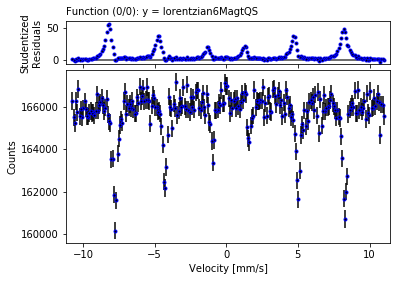

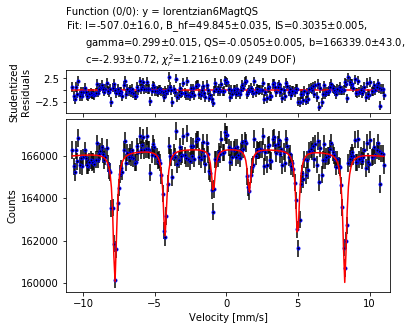


SETTINGS
  autoplot        True
  coarsen         [1]
  first_figure    0
  fpoints         [None]
  plot_all_data   [False]
  plot_bg         [True]
  plot_errors     [True]
  plot_fit        [True]
  plot_guess      [False]
  plot_guess_zoom [False]
  scale_eydata    [1.0]
  silent          False
  style_bg        [{'marker': '', 'color': 'k', 'ls': '-'}]
  style_data      [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]
  style_fit       [{'marker': '', 'color': 'r', 'ls': '-'}]
  style_guess     [{'marker': '', 'color': '0.25', 'ls': '-'}]
  subtract_bg     [False]
  xlabel          ['Velocity [mm/s]']
  xmax            [None]
  xmin            [None]
  xscale          ['linear']
  ylabel          ['Counts']
  ymax            [None]
  ymin            [None]
  yscale          ['linear']

GUESS (reduced chi^2 = 173.953 +/- 0.09, 249.0 DOF)
  I          = -2000.0
  B_hf       = 51.0
  IS         = 0.0
  gamma      = 0.5
  QS         = 0.0
  b          = 166000.0
  c         

In [12]:
# Yttrium Orthoferrite taken at room temp
data = np.loadtxt(".//data//YttriumOrtho_RT_Jan28_full.Asc", skiprows=0)
data = np.transpose(data)
data[1][511] = (data[1][510] + data[1][0])/2
ydataerr = np.sqrt(data[1])

dataL = [data[0][0:256], data[1][0:256], ydataerr[0:256]]

velocities = chan_to_velo(dataL[0], m, b)

guess = 'I=-2000, B_hf=51, IS=0, gamma=0.5, QS=0, b=1.66e5, c=-1e-3'
# guess = 'I=-2000, B_hf=51, IS=0, gamma=0.5, b=1.66e5'

# (E, I, B_hf, IS, gamma, QS, b, c):


my_fitter = s.data.fitter()
my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
              , plot_guess=False, fpoints=None, xlabel = "Velocity [mm/s]" , ylabel = "Counts")

# my_fitter.set_functions(f=lorentzian6Magt, p=guess)
my_fitter.set_functions(f=lorentzian6MagtQS, p=guess)


# lorentzian6MagtQS

my_fitter.set_data(xdata=velocities, ydata=dataL[1], eydata=dataL[2])
my_fitter.fit()

# di = my_fitter.get_fit_results()
# print(di)


In [41]:
#Yttrium orthoferrite
data = np.loadtxt(".//data//Y_ortho_T256_Jan20_full.Asc", skiprows=0)

data = np.transpose(data)
data[1][511] = (data[1][510] + data[1][0])/2
ydataerr = np.sqrt(data[1])

dataL = [data[0][0:256], data[1][0:256], ydataerr[0:256]]

tempPoints = [[],[], []]

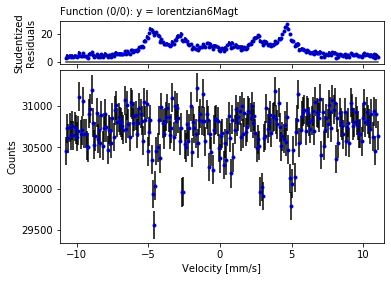

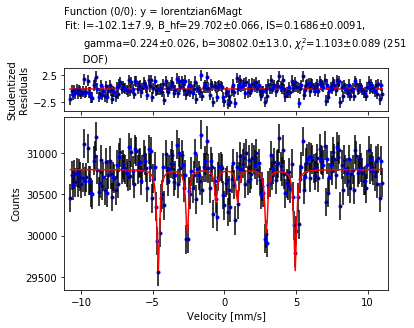


SETTINGS
  autoplot        True
  coarsen         [1]
  first_figure    0
  fpoints         [None]
  plot_all_data   [False]
  plot_bg         [True]
  plot_errors     [True]
  plot_fit        [True]
  plot_guess      [False]
  plot_guess_zoom [False]
  scale_eydata    [1.0]
  silent          False
  style_bg        [{'marker': '', 'color': 'k', 'ls': '-'}]
  style_data      [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]
  style_fit       [{'marker': '', 'color': 'r', 'ls': '-'}]
  style_guess     [{'marker': '', 'color': '0.25', 'ls': '-'}]
  subtract_bg     [False]
  xlabel          ['Velocity [mm/s]']
  xmax            [None]
  xmin            [None]
  xscale          ['linear']
  ylabel          ['Counts']
  ymax            [None]
  ymin            [None]
  yscale          ['linear']

GUESS (reduced chi^2 = 126.129 +/- 0.089, 251.0 DOF)
  I          = -300.0
  B_hf       = 29.0
  IS         = 0.0
  gamma      = 1.0
  b          = 30000.0

FIT RESULTS (reduced chi^2 = 1.

In [42]:
# should be data taken at 297 (but could be wrong)
data = np.loadtxt(".//data//Y_ortho_T256_Jan20_full.Asc", skiprows=0)
data = np.transpose(data)
data[1][511] = (data[1][510] + data[1][0])/2
ydataerr = np.sqrt(data[1])

dataL = [data[0][0:256], data[1][0:256], ydataerr[0:256]]

velocities = chan_to_velo(dataL[0], m, b)

guess = 'I=-300, B_hf=29, IS=0, gamma=1, b=3e4'

my_fitter = s.data.fitter()
my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
              , plot_guess=False, fpoints=None, xlabel = "Velocity [mm/s]" , ylabel = "Counts")

my_fitter.set_functions(f=lorentzian6Magt, p=guess)

my_fitter.set_data(xdata=velocities, ydata=dataL[1], eydata=dataL[2])
my_fitter.fit()
# print(my_fitter.get_fit_results())

# results = [getFits_lor(my_fitter, 0), getFits_lor(my_fitter, 1), getFits_lor(my_fitter, 2)]

### Fitting Data from malfunctioning oven

In [43]:
# data_T256 = np.loadtxt(".//data//Y_ortho_T256_Jan20_full.Asc", skiprows=0)
# guess_T256 = 'center=0, dist=4.8, gamma=1, A=-1500, center_2=0, dist_2=2.7, gamma_2=2, A_2=-1300, center_3=0, dist_3=1.1, gamma_3=0.7, A_3=-1000, b=3e4'

# fit_T256 = fitYtt(data_T256, guess_T256, 6)
# # print(fit_T256[2])

# tempPoints[0].append(256)
# tempPoints[1].append(fit_T256[2][1][0])
# tempPoints[2].append(fit_T367[2][1][1])

In [44]:
# data_T358 = np.loadtxt(".//data//Y_ortho_T358_Jan21_full.Asc", skiprows=0)

# guess_T358 = 'center=0, dist=0.1, gamma=1, A=3e4, b=4e5'
# fit_T358 = fitYtt(data_T358, guess_T358, 2)

# tempPoints[0].append(358)
# tempPoints[1].append(fit_T358[0][1][0])
# tempPoints[2].append(fit_T367[0][1][1])

In [45]:
# data_T365 = np.loadtxt(".//data//Y_ortho_T365_Jan21_full.Asc", skiprows=0)
# guess_T365 = 'center=0, dist=0.1, gamma=1, A=3e4, b=4e6'

# fit_T365 = fitYtt(data_T365, guess_T365, 2)
# tempPoints[0].append(365)
# tempPoints[1].append(fit_T365[0][1][0])
# tempPoints[2].append(fit_T367[0][1][1])

In [46]:
# data_T367 = np.loadtxt(".//data//Y_ortho_T367_Jan22_full.Asc", skiprows=0)
# guess_T367 = 'center=0, dist=0.1, gamma=0.1, A=3e4, b=4e5'

# fit_T367 = fitYtt(data_T367, guess_T367, 2)
# tempPoints[0].append(367)
# tempPoints[1].append(fit_T367[0][1][0])
# tempPoints[2].append(fit_T367[0][1][1])

In [47]:
# data_T309 = np.loadtxt(".//data//Y_ortho_T309_Jan22_full.Asc", skiprows=0)
# guess_T309 = 'center=0, dist=0.1, gamma=0.1, A=3e, b=45e4'

# fit_T309 = fitYtt(data_T309, guess_T309, 2)
# tempPoints[0].append(309)
# tempPoints[1].append(fit_T309[0][1][0])
# tempPoints[2].append(fit_T309[0][1][1])

In [48]:
# #distance of calibration outside peaks
# cal = [5.31149, 0.00055]
# err = [np.abs(i) for i in tempPoints[2]]

# plt.errorbar(tempPoints[0], np.abs(tempPoints[1]), yerr=0, linestyle=" ", marker="o")
# # plt.axhline(cal[0], color='g')

# # tempPoints[2]

# plt.grid()
# plt.ylabel('Dist [mm/sec]')
# plt.xlabel('Temp')

# plt.show

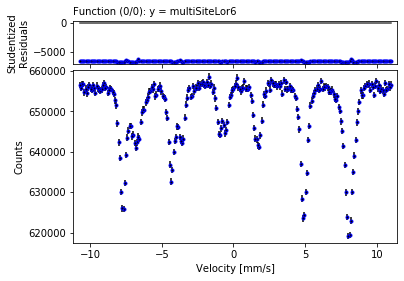

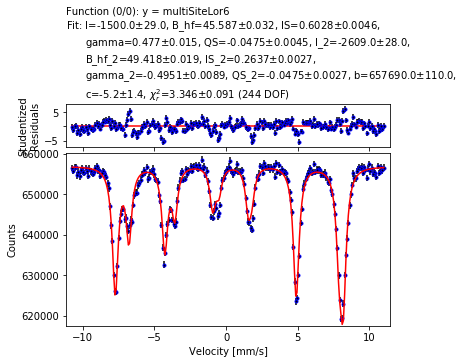


SETTINGS
  autoplot        True
  coarsen         [1]
  first_figure    0
  fpoints         [None]
  plot_all_data   [False]
  plot_bg         [True]
  plot_errors     [True]
  plot_fit        [True]
  plot_guess      [False]
  plot_guess_zoom [False]
  scale_eydata    [1.0]
  silent          False
  style_bg        [{'marker': '', 'color': 'k', 'ls': '-'}]
  style_data      [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]
  style_fit       [{'marker': '', 'color': 'r', 'ls': '-'}]
  style_guess     [{'marker': '', 'color': '0.25', 'ls': '-'}]
  subtract_bg     [False]
  xlabel          ['Velocity [mm/s]']
  xmax            [None]
  xmin            [None]
  xscale          ['linear']
  ylabel          ['Counts']
  ymax            [None]
  ymin            [None]
  yscale          ['linear']

GUESS (reduced chi^2 = 45792855.865 +/- 0.091, 244.0 DOF)
  I          = -30000.0
  B_hf       = 46.0
  IS         = 0.65
  gamma      = 0.1
  QS         = 0.1
  I_2        = -30000.0
  B_

In [63]:
# Magnetite
#QS with multisite fit
data = np.loadtxt(".//data//Magnetite_Jan23_full.Asc", skiprows=0)
data = np.transpose(data)
data[1][511] = (data[1][510] + data[1][0])/2
ydataerr = np.sqrt(data[1])

dataL = [data[0][0:256], data[1][0:256], ydataerr[0:256]]

velocities = chan_to_velo(dataL[0], m, b)

#textbook(B_HF), paper - JM Daniels, decent fit
# guess = 'I=-3e4, B_hf=45, IS=0.8, gamma=0.1, QS=0.1, I_2=-3e4, B_hf_2=49, IS_2=0.4, gamma_2=0.1, QS_2=0.1, b=6e6'
#paper - BJ Evans, lower chiSquared then above
guess = 'I=-3e4, B_hf=46, IS=0.65, gamma=0.1, QS=0.1, I_2=-3e4, B_hf_2=49, IS_2=0.25, gamma_2=0.1, QS_2=0.1, b=6e6, c=-1e-3'

my_fitter = s.data.fitter()
my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
              , plot_guess=False, fpoints=None, xlabel = "Velocity [mm/s]" , ylabel = "Counts")

my_fitter.set_functions(f=multiSiteLor6, p=guess)


my_fitter.set_data(xdata=velocities, ydata=dataL[1], eydata=dataL[2])
my_fitter.fit()
# print(my_fitter.get_fit_results())

# results = [getFits_lor(my_fitter, 0), getFits_lor(my_fitter, 1), getFits_lor(my_fitter, 2)]

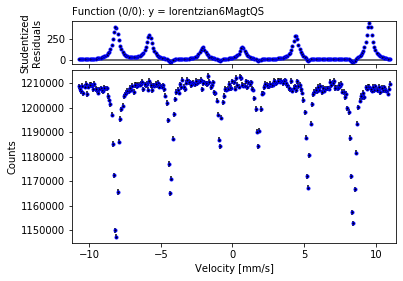

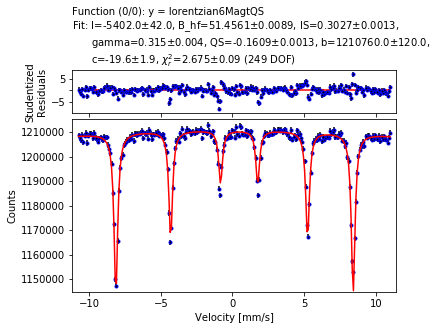


SETTINGS
  autoplot        True
  coarsen         [1]
  first_figure    0
  fpoints         [None]
  plot_all_data   [False]
  plot_bg         [True]
  plot_errors     [True]
  plot_fit        [True]
  plot_guess      [False]
  plot_guess_zoom [False]
  scale_eydata    [1.0]
  silent          False
  style_bg        [{'marker': '', 'color': 'k', 'ls': '-'}]
  style_data      [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]
  style_fit       [{'marker': '', 'color': 'r', 'ls': '-'}]
  style_guess     [{'marker': '', 'color': '0.25', 'ls': '-'}]
  subtract_bg     [False]
  xlabel          ['Velocity [mm/s]']
  xmax            [None]
  xmin            [None]
  xscale          ['linear']
  ylabel          ['Counts']
  ymax            [None]
  ymin            [None]
  yscale          ['linear']

GUESS (reduced chi^2 = 10594.367 +/- 0.09, 249.0 DOF)
  I          = -40000.0
  B_hf       = 55.0
  IS         = 0.0
  gamma      = 0.5
  QS         = 0.7
  b          = 1210000.0
  c     

In [62]:
# Hematite
# small QS seen
data = np.loadtxt(".//data//Hematite_Jan24_full.Asc", skiprows=0)
data = np.transpose(data)
data[1][511] = (data[1][510] + data[1][0])/2
ydataerr = np.sqrt(data[1])
dataL = [data[0][0:256], data[1][0:256], ydataerr[0:256]]

guess = 'I=-4e4, B_hf=55, IS=0, gamma=.5, QS=.7, b=1.21e6, c=-1e-3'

my_fitter = s.data.fitter()
my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
              , plot_guess=False, fpoints=None, xlabel = "Velocity [mm/s]" , ylabel = "Counts")

my_fitter.set_functions(f=lorentzian6MagtQS, p=guess)

my_fitter.set_data(xdata=velocities, ydata=dataL[1], eydata=dataL[2])
my_fitter.fit()


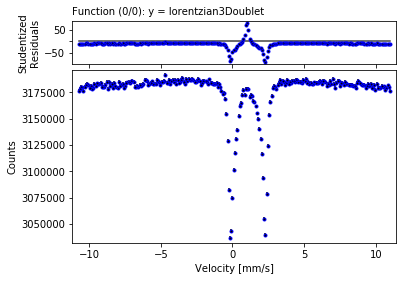

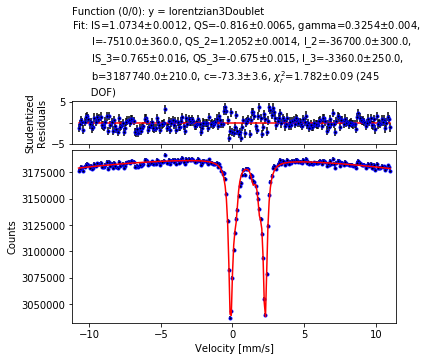


SETTINGS
  autoplot        True
  coarsen         [1]
  first_figure    0
  fpoints         [None]
  plot_all_data   [False]
  plot_bg         [True]
  plot_errors     [True]
  plot_fit        [True]
  plot_guess      [False]
  plot_guess_zoom [False]
  scale_eydata    [1.0]
  silent          False
  style_bg        [{'marker': '', 'color': 'k', 'ls': '-'}]
  style_data      [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]
  style_fit       [{'marker': '', 'color': 'r', 'ls': '-'}]
  style_guess     [{'marker': '', 'color': '0.25', 'ls': '-'}]
  subtract_bg     [False]
  xlabel          ['Velocity [mm/s]']
  xmax            [None]
  xmin            [None]
  xscale          ['linear']
  ylabel          ['Counts']
  ymax            [None]
  ymin            [None]
  yscale          ['linear']

GUESS (reduced chi^2 = 363.61 +/- 0.09, 245.0 DOF)
  IS         = 1.0
  QS         = 0.05
  gamma      = 0.2
  I          = -25000.0
  QS_2       = 1.0
  I_2        = -5000.0
  IS_3       

In [52]:
#Tourmaline

data = np.loadtxt(".//data//Tourmaline_Jan27_full.Asc", skiprows=0)

data = np.transpose(data)
data[1][511] = (data[1][510] + data[1][0])/2
ydataerr = np.sqrt(data[1])

dataL = [data[0][0:256], data[1][0:256], ydataerr[0:256]]
velocities = chan_to_velo(dataL[0], m, b)

my_fitter = s.data.fitter()
my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
              , plot_guess=False, fpoints=None, xlabel = "Velocity [mm/s]" , ylabel = "Counts")
# help(s.data.fitter)

# def lorentzian3Doublet(E, IS, QS, gamma, I, QS_2, I_2, QS_3, I_3, b):

guess= 'IS=1.0, QS=0.05, gamma=0.2, I=-2.5e4, QS_2=1.0, I_2=-5e3, IS_3=0.2, QS_3=0.2, I_3=-5e3, b=3.2e6, c=-1e-3'
my_fitter.set_functions(f=lorentzian3Doublet, p=guess)

my_fitter.set_data(xdata=velocities, ydata=dataL[1], eydata=dataL[2])
my_fitter.fit()
# print(my_fitter.get_fit_results())
# resultsLS = getFits_lor(my_fitter, 0)
